## Bootstrap
Bootstrap allows you to repeatedly extract subsamples from the sample obtained in the framework of the experiment.

In the obtained subsamples, statistics are considered (mean, median, etc.)

From the statistics, you can get its distribution and take the confidence interval

CLT, for example, does not allow you to build a confidence interval for the median, but bootstrap can do this.

In [62]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import kstest

from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import pingouin as pg
from urllib.parse import urlencode
import requests

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [56]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
df_url    = 'https://disk.yandex.ru/d/1TFOJ7Z80VAEFw'

df_final_url = base_url + urlencode(dict(public_key = df_url)) 
response     = requests.get(df_final_url) 
download_url = response.json()['href']

download_response = requests.get(download_url) 
df = pd.read_csv(download_url, sep = ';') 

In [3]:
df.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [11]:
#prepare the data
df.value = df.value.str.replace(',' , '.').astype(float)

In [12]:
#Check that the numbers of test and control observations are the same
df_sep = df.pivot(columns = 'experimentVariant', values = 'value').reset_index()
df_sep.fillna(0).head()

experimentVariant,index,Control,Treatment
0,0,10.380495,0.0
1,1,9.546867,0.0
2,2,11.088215,0.0
3,3,10.147274,0.0
4,4,9.789808,0.0


In [13]:
test_cnt = df_sep.Treatment.count()
test_cnt

500

In [14]:
control_cnt = df_sep.Control.count()
control_cnt

500

In [15]:
#it will be easier) 
df_control = df.query('experimentVariant == "Control"')

In [16]:
df_test = df.query('experimentVariant == "Treatment"')

In [68]:
#Let's check our distributions for normality
shapiro(df_control.value)

ShapiroResult(statistic=0.9959248900413513, pvalue=0.22416365146636963)

In [66]:
kstest(df_control.value, 'norm')

KstestResult(statistic=0.9999999999388864, pvalue=0.0)

In [61]:
shapiro(df_test.value)

ShapiroResult(statistic=0.07038933038711548, pvalue=1.0930128021733573e-43)

In [67]:
kstest(df_test.value, 'norm')

KstestResult(statistic=0.9999999999388864, pvalue=0.0)

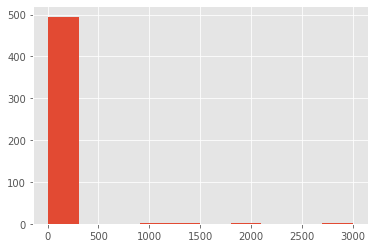

In [69]:
df_test.value.hist()

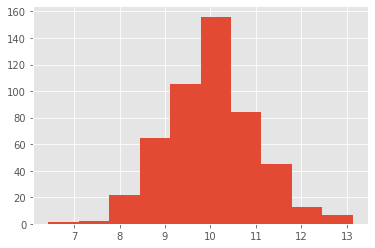

In [70]:
df_control.value.hist()

In [39]:
pg.normality(data = df, dv = "value", 
                   group = "experimentVariant", method = "normaltest")

,W,pval,normal
Control,2.943459,2.295282e-01,True
Treatment,929.515767,1.439514e-202,False


In [17]:
#t-test
ttest_ind(df_test.value, 
         df_control.value)

Ttest_indResult(statistic=2.0729020485356604, pvalue=0.038437593613498765)

In [35]:
x = df_test.value.mean()
x

27.321499056661573

In [36]:
y = df_control.value.mean()
y

10.026866533804297

In [38]:
precent = 100 - (y / x * 100)
precent.round(2)

63.3

In [34]:
#mannwhitneyu
mannwhitneyu(df_test.value, df_control.value, method = "asymptotic")

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)

In [52]:
#bootstrap
def get_bootstrap(
    data_column_1, # numeric values ​​of the first sample
    data_column_2, # numeric values ​​of the second sample
    boot_it = 1000, # number of bootstrap subsamples
    statistic = np.mean, # the statistics we are interested in
    bootstrap_conf_level = 0.95 # p-value
):
    boot_data = []
    for i in tqdm(range(boot_it)): # extract subsamples
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # return parameter
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2)) # mean() - apply statistics
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Visualisation
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin = 0, ymax = 50, linestyle = '--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

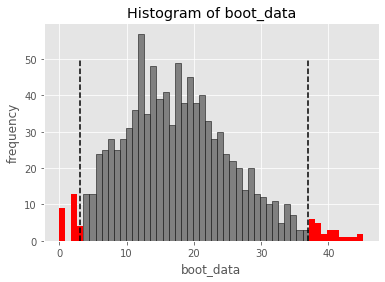

In [53]:
booted_data = get_bootstrap(df_test.value, df_control.value)

In [54]:
#p-value
booted_data["p_value"]

0.035880928895180714

In [55]:
#confidence interval
booted_data["quants"]

,0
0.025,3.064087
0.975,37.016873


## Conclusion
T-test and bootstrap showed similar p-values.

In our case, the bootstrap method will be the most effective. the distribution of the test group is not normal so t-test is not suitable for us. The Mann-Whitney criterion does not suit us because we are not sure about the independence of the variables. Just the same, bootstrap can work with non-normally distributed dependent samples.